# 3D Deconvolution Benchmark: Julia

---
## Setup

In [46]:
using DeconvOptim, Images, FFTW, Noise, ImageView, BenchmarkTools, Plots

---
## Test Image



In [10]:
img = convert(Array{Float32}, channelview(load("simple_3d_ball.tif")));

In [11]:
psf = ifftshift(convert(Array{Float32}, channelview(load("simple_3d_psf.tif"))));

In [7]:
# psf ./= sum(psf)
# # create a blurred, noisy version of that image
# img_b = conv(img, psf, [1, 2, 3])
# img_n = poisson(img_b, 300);
# save("simple_3d_ball_blurred.tif", img_n)

In [12]:
img_n = convert(Array{Float32}, channelview(load("simple_3d_ball_blurred.tif")));

In [13]:
reg = TV(num_dims=3, sum_dims=[1, 2, 3]);

In [14]:
res2, ores = deconvolution(img_n, psf, regularizer=reg, loss=Poisson(),
                          λ=0.05, padding=0, iterations=10);

In [15]:
@benchmark deconvolution(img_n, psf, regularizer=reg, loss=Poisson(), λ=0.05, padding=0, iterations=10)  samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):   79.100 ms … 234.098 ms  ┊ GC (min … max):  0.57% … 62.93%
 Time  (median):      85.764 ms               ┊ GC (median):     2.56%
 Time  (mean ± σ):   111.198 ms ±  51.809 ms  ┊ GC (mean ± σ):  26.24% ± 23.02%

  ▁█                                                             
  ███▅▄▆▅▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▃▄▄▃▃ ▃
  79.1 ms          Histogram: frequency by time          225 ms <

 Memory estimate: 147.59 MiB, allocs estimate: 2671.

In [16]:
res, ores = deconvolution(img_n, psf, regularizer=nothing, iterations=10);

In [17]:
@benchmark deconvolution(img_n, psf, regularizer=nothing, iterations=10) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  71.765 ms … 209.148 ms  ┊ GC (min … max): 0.31% … 64.26%
 Time  (median):     74.766 ms               ┊ GC (median):    1.55%
 Time  (mean ± σ):   78.941 ms ±  22.843 ms  ┊ GC (mean ± σ):  7.09% ± 11.04%

  ▇█▂                                                           
  ███▁▁▅▆▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▅
  71.8 ms       Histogram: log(frequency) by time       206 ms <

 Memory estimate: 93.57 MiB, allocs estimate: 2207.

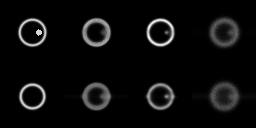

In [18]:
img_comb1 = [img[:, : ,32] res2[:, :, 32] res[:, :, 32] img_n[:, :, 32]]
img_comb2 = [img[:, : ,38] res2[:, :, 38] res[:, :, 38] img_n[:, :, 38]]

img_comb = cat(img_comb1, img_comb2, dims=1)
img_comb ./= maximum(img_comb)

# imshow([img[:, :, 20:end] res2[:, :, 20:end] res[:, :, 20:end] img_n[:, :, 20:end]])
colorview(Gray, img_comb)

---
## Cell 3D

In [24]:
cell = convert(Array{Float32}, channelview(load("cells3d_convolved.tiff")));

In [25]:
cell_psf = convert(Array{Float32}, channelview(load("cells3d_psf.tiff")));

In [26]:
cell /= maximum(cell);
cell_psf /= maximum(cell_psf);

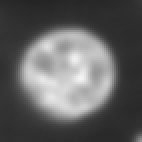

In [27]:
colorview(Gray, cell[:,:,30])

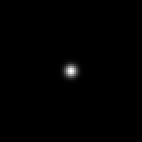

In [28]:
colorview(Gray, cell_psf[:,:,30])

In [29]:
cell_res, cell_ores = deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=10);

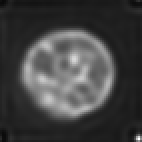

In [30]:
colorview(Gray, cell_res[:,:,30]/maximum(cell_res[:,:,30]))

In [31]:
@benchmark deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=10) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  427.467 ms … 577.024 ms  ┊ GC (min … max): 0.07% … 23.21%
 Time  (median):     431.148 ms               ┊ GC (median):    0.51%
 Time  (mean ± σ):   436.169 ms ±  20.120 ms  ┊ GC (mean ± σ):  1.16% ±  3.25%

  ▇█                                                             
  ███▃▄▃▄▄▄▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  427 ms           Histogram: frequency by time          563 ms <

 Memory estimate: 105.90 MiB, allocs estimate: 2196.

---
## Cube of Spherical Beads

In [36]:
# Cargamos la imagen

cube = convert(Array{Float32}, channelview(load("cubeConvolved.tif")));

# Cargamos la psf

cubePSF = convert(Array{Float32}, channelview(load("PSF.tif")));

cube /= maximum(cube);
cubePSF /= maximum(cubePSF);

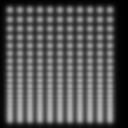

In [37]:
colorview(Gray, cube[:,:,30])

In [38]:
number_of_iterations = 30

cube_res, cube_ores = deconvolution(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations);

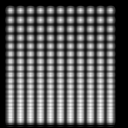

In [39]:
colorview(Gray, cube_res[:,:,30]/maximum(cube_res[:,:,30]))

In [40]:
@benchmark deconvolution(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 26 samples with 1 evaluation.
 Range (min … max):  2.231 s …   2.282 s  ┊ GC (min … max): 6.93% … 7.15%
 Time  (median):     2.250 s              ┊ GC (median):    7.08%
 Time  (mean ± σ):   2.251 s ± 11.466 ms  ┊ GC (mean ± σ):  7.10% ± 0.11%

  ▃         ▃       █     █       ▃    ▃                     
  █▁▁▁▁▁▇▁▁▇█▁▁▁▇▇▁▇█▁▇▇▁▁█▁▁▇▇▁▁▁█▇▁▁▁█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  2.23 s         Histogram: frequency by time        2.28 s <

 Memory estimate: 1.36 GiB, allocs estimate: 5851.

---
## C. elegans embryo

In [ ]:
import Pkg;

Pkg.add("FileIO")

In [83]:
using FileIO
using Images

function load_image_stack(folder_path::String)
    # Listar todos los archivos en la carpeta y ordenar
    files = sort(filter(f -> endswith(f, ".tif") || endswith(f, ".png") || endswith(f, ".jpg"), readdir(folder_path)))

    # Leer la primera imagen para obtener las dimensiones
    first_image = load(joinpath(folder_path, files[1]))
    height, width = size(first_image)

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = Array{Float32, 3}(undef, length(files), height, width)

    # Cargar cada imagen en la matriz 3D y convertir a Float32
    for (i, file) in enumerate(files)
        image = load(joinpath(folder_path, file))
        image_stack[i, :, :] = float(image)
    end

    return image_stack
end


load_image_stack (generic function with 1 method)

### Canal 1

In [84]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = "/Users/yi/TFGNotebook/CElegans-CY3"
psfPath = "/Users/yi/TFGNotebook/PSF-CElegans-CY3"

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[:, 1:356, 1:336]
psf_stack = load_image_stack(psfPath)[:, 205:508, 185:488] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack))
println("image_stack element type: ", eltype(image_stack))
println(size(psf_stack))


(104, 356, 336)
image_stack element type: Float32
(104, 304, 304)


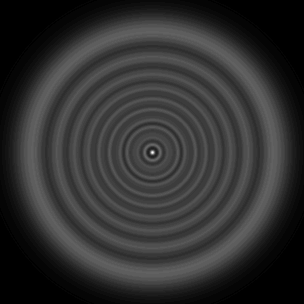

In [110]:
colorview(Gray, psf_stack[1,:,:]/maximum(psf_stack[1,:,:]))


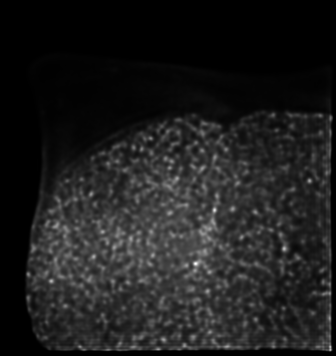

In [112]:
num_iter = 50

canal1_res, canal1_ores = deconvolution(image_stack, ifftshift(psf_stack), regularizer=nothing, iterations=num_iter);

colorview(Gray, canal1_res[52,:,:]/maximum(canal1_res[52,:,:]))

In [117]:
@benchmark deconvolution(image_stack, ifftshift(psf_stack), regularizer=nothing, iterations=1)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.628 s …   2.647 s  ┊ GC (min … max): 14.99% … 15.17%
 Time  (median):     2.638 s              ┊ GC (median):    15.08%
 Time  (mean ± σ):   2.638 s ± 13.902 ms  ┊ GC (mean ± σ):  15.08% ±  0.13%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.63 s         Histogram: frequency by time        2.65 s <

 Memory estimate: 2.62 GiB, allocs estimate: 558.

### Canal 2

In [120]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = "/Users/yi/TFGNotebook/CElegans-DAPI"
psfPath2 = "/Users/yi/TFGNotebook/PSF-CElegans-DAPI"

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[:, 1:356, 1:336]
psf_stack2 = load_image_stack(psfPath2)[:, 205:508, 185:488] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack2))
println("image_stack element type: ", eltype(image_stack2))
println(size(psf_stack2))

(104, 356, 336)
image_stack element type: Float32
(104, 304, 304)


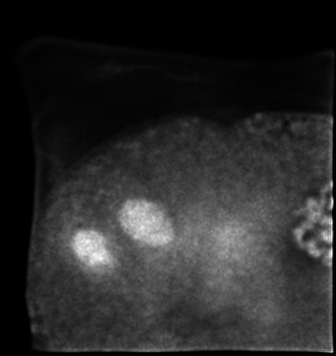

In [121]:
canal2_res, canal2_ores = deconvolution(image_stack2, ifftshift(psf_stack2), regularizer=nothing, iterations=num_iter);

colorview(Gray, canal2_res[52,:,:]/maximum(canal2_res[52,:,:]))

### Canal 3

In [123]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = "/Users/yi/TFGNotebook/CElegans-FITC"
psfPath3 = "/Users/yi/TFGNotebook/PSF-CElegans-FITC"

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[:, 1:356, 1:336]
psf_stack3 = load_image_stack(psfPath3)[:, 205:508, 185:488] #mitad +152

# Verificar las dimensiones de las matrices 3D
println(size(image_stack3))
println("image_stack element type: ", eltype(image_stack3))
println(size(psf_stack3))

(104, 356, 336)
image_stack element type: Float32
(104, 304, 304)


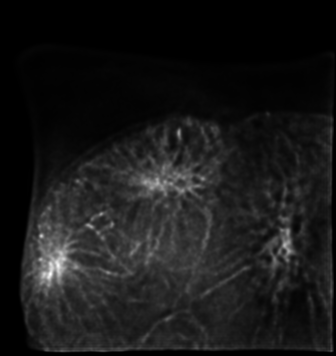

In [124]:
canal3_res, canal3_ores = deconvolution(image_stack3, ifftshift(psf_stack3), regularizer=nothing, iterations=num_iter);

colorview(Gray, canal3_res[52,:,:]/maximum(canal3_res[52,:,:]))

### Combinación de canales

He hecho la combinación de canales pero no se me muestra como en python, será por el tipo de imagen que es FLOAT32 y los plots de Julia que sean diferentes.

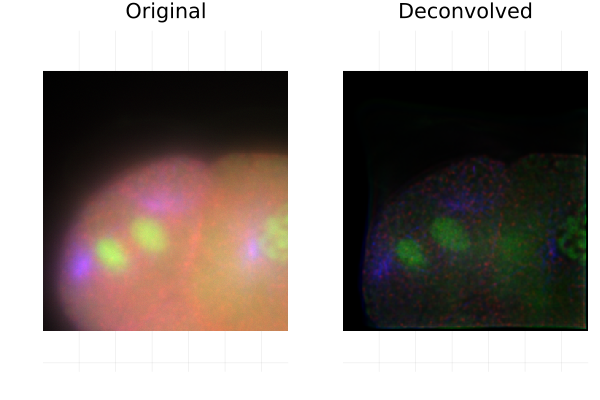

In [154]:
using Plots
using Images
using ColorTypes

# Función para normalizar una imagen
function normalize(image::AbstractArray)
    min_val = minimum(image)
    max_val = maximum(image)
    if min_val == max_val
        return zeros(size(image))  # O ones(size(image)), dependiendo de tu preferencia
    end
    return (image .- min_val) ./ (max_val - min_val)
end

# Normalizar los canales
deconvolved_stack_R = normalize(canal1_res)
deconvolved_stack_G = normalize(canal2_res)
deconvolved_stack_B = normalize(canal3_res)

# Crear una imagen RGB para la visualización
function create_rgb_image(r::AbstractArray, g::AbstractArray, b::AbstractArray)
    # Verificar que todas las dimensiones sean iguales
    height, width = size(r)
    if size(g) != (height, width) || size(b) != (height, width)
        throw(ArgumentError("Las dimensiones de las imágenes R, G y B deben coincidir."))
    end

    # Crear una matriz de imágenes RGB
    rgb_image = Array{RGB{Float32}, 2}(undef, height, width)
    rgb_image[:, :] .= RGB{Float32}[RGB(r[i, j], g[i, j], b[i, j]) for i in 1:height, j in 1:width]
    return rgb_image
end

# Combinar los canales en una imagen RGB
deconvolved_image_color = create_rgb_image(deconvolved_stack_R[52, :, :],
                                           deconvolved_stack_G[52, :, :],
                                           deconvolved_stack_B[52, :, :])

# Normalizar y combinar los planos para la visualización
original_image_rgb = create_rgb_image(normalize(image_stack[52, :, :]),
                                       normalize(image_stack2[52, :, :]),
                                       normalize(image_stack3[52, :, :]))

# Mostrar las imágenes
plot(
    heatmap(original_image_rgb, title="Original", axis=false, color=:viridis),
    heatmap(deconvolved_image_color, title="Deconvolved", axis=false, color=:viridis),
    layout=(1, 2)
)


